In [1]:
from __future__ import division
from __future__ import print_function
from __future__ import absolute_import
from __future__ import unicode_literals

import math
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.linear_model as linear_model

import scipy
import sklearn

import sys
## change path based on own directory
sys.path.append('E:/UT Austin Courses/Spring 2019/Special Topics in Machine Learning/Mini Project/influence-release-master/') 

sns.set(color_codes=True)

import tensorflow as tf
from tensorflow.contrib.learn.python.learn.datasets import base

from influence.binaryLogisticRegressionWithLBFGS import BinaryLogisticRegressionWithLBFGS
from influence.smooth_hinge import SmoothHinge
import influence.dataset as dataset
from influence.dataset import DataSet

%matplotlib inline
%load_ext autoreload
%autoreload 2

np.random.seed(42)

Using TensorFlow backend.


In [2]:
def examine_vec(x, verbose=False):
    assert len(feature_names) == len(x)
    print('Age: %s' % x[age_var_indices])
    if verbose:
        for feature_name, val in zip(feature_names, x):
            print('%32s: %.6f' % (feature_name, val))
    
def examine_train_point(idx, verbose=False):
    print('Label: %s' % Y_train[idx])
    examine_vec(modified_X_train[idx, :], verbose)
    
def examine_test_point(idx, verbose=False):
    print('Label: %s' % Y_test[idx])
    examine_vec(X_test[idx, :], verbose)

# Read and process dataset

In [3]:
df = pd.read_csv('bank-additional-full.csv',sep=';') #UCI Bank Marketing Dataset
# Use this if you are not running this in CodaLab
# df = pd.read_csv('../data/diabetic_data.csv')

In [4]:
df

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [5]:
# Convert categorical variables into numeric ones

X = pd.DataFrame()

# Numerical variables that we can pull directly
X = df.loc[
    :, 
    [
        'age',
        'duration',
        'campaign',
        'pdays',
        'previous',
        'emp.var.rate',
        'cons.price.idx',
        'cons.conf.idx', 
        'euribor3m', 
        'nr.employed'
    ]]

categorical_var_names = [
    'job',
    'marital',
    'education', 
    'default',
    'housing',
    'loan',
    'contact',
    'month',
    'day_of_week',
    'poutcome'
]
for categorical_var_name in categorical_var_names:
    categorical_var = pd.Categorical(
        df.loc[:, categorical_var_name])
    
    # Just have one dummy variable if it's boolean
    if len(categorical_var.categories) == 2:
        drop_first = True
    else:
        drop_first = False

    dummies = pd.get_dummies(
        categorical_var, 
        prefix=categorical_var_name,
        drop_first=drop_first)
    
    X = pd.concat([X, dummies], axis=1)

In [6]:
### Set the Y labels
readmitted = pd.Categorical(df.y)
Y = np.copy(readmitted.codes)

In [7]:
# 1(yes)  become -1, while 0(no) becomes 1
Y[Y >= 1] = -1
Y[Y == 0] = 1

In [8]:
# Map to feature names
feature_names = X.columns.values

In [9]:
feature_names

array(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_admin.', 'job_blue-collar', 'job_entrepreneur',
       'job_housemaid', 'job_management', 'job_retired',
       'job_self-employed', 'job_services', 'job_student',
       'job_technician', 'job_unemployed', 'job_unknown',
       'marital_divorced', 'marital_married', 'marital_single',
       'marital_unknown', 'education_basic.4y', 'education_basic.6y',
       'education_basic.9y', 'education_high.school',
       'education_illiterate', 'education_professional.course',
       'education_university.degree', 'education_unknown', 'default_no',
       'default_unknown', 'default_yes', 'housing_no', 'housing_unknown',
       'housing_yes', 'loan_no', 'loan_unknown', 'loan_yes',
       'contact_telephone', 'month_apr', 'month_aug', 'month_dec',
       'month_jul', 'month_jun', 'month_mar', 'month_may', 'month_nov',
       'month_oct', 'm

In [10]:
### Find indices of housing loan features
# these look like index of 'housing_no', 'housing_unknown', 'housing_yes'
loan_var = pd.Categorical(df.loc[:, 'housing'])
loan_var_names = ['housing_%s' % loan_var_name for loan_var_name in loan_var.categories]    
loan_var_indices = []
for loan_var_name in loan_var_names:
    loan_var_indices.append(np.where(X.columns.values == loan_var_name)[0][0])
loan_var_indices = np.array(loan_var_indices, dtype=int)

In [11]:
loan_var_indices

array([37, 38, 39])

In [12]:
### Split into training and test sets. 
# For convenience, we balance the training set to have 10k positives and 10k negatives.

np.random.seed(2)
num_examples = len(Y)
assert X.shape[0] == num_examples
num_train_examples = 20000
num_train_examples_per_class = int(num_train_examples / 2)
num_test_examples = num_examples - num_train_examples
assert num_test_examples > 0

pos_idx = np.where(Y == 1)[0]
neg_idx = np.where(Y == -1)[0]
np.random.shuffle(pos_idx)
np.random.shuffle(neg_idx)
assert len(pos_idx) + len(neg_idx) == num_examples

train_idx = np.concatenate((pos_idx[:num_train_examples_per_class], neg_idx[:num_train_examples_per_class]))
test_idx = np.concatenate((pos_idx[num_train_examples_per_class:], neg_idx[num_train_examples_per_class:]))
np.random.shuffle(train_idx)
np.random.shuffle(test_idx)

X_train = np.array(X.iloc[train_idx, :], dtype=np.float32)
Y_train = Y[train_idx]

X_test = np.array(X.iloc[test_idx, :], dtype=np.float32)
Y_test = Y[test_idx]

train = DataSet(X_train, Y_train)
validation = None
test = DataSet(X_test, Y_test)
data_sets = base.Datasets(train=train, validation=validation, test=test)

lr_train = DataSet(X_train, np.array((Y_train + 1) / 2, dtype=int))
lr_validation = None
lr_test = DataSet(X_test, np.array((Y_test + 1) / 2, dtype=int))
lr_data_sets = base.Datasets(train=lr_train, validation=lr_validation, test=lr_test)

test_children_idx = np.where(X_test[:, loan_var_indices[2]] == 1)[0]

In [13]:
# Train a model on the training set

num_classes = 2

input_dim = X_train.shape[1]
weight_decay = 0.0001
batch_size = 100
initial_learning_rate = 0.001 
keep_probs = None
decay_epochs = [1000, 10000]
max_lbfgs_iter = 1000
use_bias = True

tf.reset_default_graph()

orig_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='diabetes_logreg')

orig_model.train()

orig_model_preds = orig_model.sess.run(
    orig_model.preds,
    feed_dict=orig_model.all_test_feed_dict)
orig_model_preds = orig_model_preds[test_children_idx, 0]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Total number of parameters: 62


C:\Users\rcron\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Using normal model


C:\Users\rcron\Anaconda3\envs\tensorflow_env\lib\site-packages\sklearn\linear_model\logistic.py:758: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


LBFGS training took [1000] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.3209708
Train loss (w/o reg) on all data: 0.32082218
Test loss (w/o reg) on all data: 0.24185371
Train acc on all data:  0.8626366120218579
Test acc on all data:   0.9155115262919994
Norm of the mean of gradients: 0.017369686
Norm of the params: 1.7240429


In [15]:
# Remove from the training set all but one person having a housing loan who did not accept bank term deposit 
mask_to_remove = (Y_train == 1) & (X_train[:, loan_var_indices[2]] == 1)   
idx_to_remove = np.where(mask_to_remove)[0][:-1] # Keep 1 of them
mask_to_keep = np.array([True] * len(mask_to_remove), dtype=bool)
mask_to_keep[idx_to_remove] = False

modified_X_train = np.copy(X_train)
modified_Y_train = np.copy(Y_train)

modified_X_train = modified_X_train[mask_to_keep, :]
modified_Y_train = modified_Y_train[mask_to_keep]

print('In original data, %s/%s people have a housing loan who accepted bank term deposit.' % (
        np.sum((Y_train == -1) & (X_train[:, loan_var_indices[2]] == 1)),
        np.sum((X_train[:, loan_var_indices[2]] == 1))))
print('In modified data, %s/%s people have a housing loan who accepted bank term deposit.' % (
        np.sum((modified_Y_train == -1) & (modified_X_train[:, loan_var_indices[2]] == 1)),
        np.sum((modified_X_train[:, loan_var_indices[2]] == 1))))

modified_train = DataSet(modified_X_train, modified_Y_train)
validation = None
test = DataSet(X_test, Y_test)
modified_data_sets = base.Datasets(train=modified_train, validation=validation, test=test)


lr_modified_train = DataSet(modified_X_train, np.array((modified_Y_train + 1) / 2, dtype=int))
lr_modified_data_sets = base.Datasets(train=lr_modified_train, validation=lr_validation, test=lr_test)

In original data, 2507/7737 people have a housing loan who accepted bank term deposit.
In modified data, 2507/2508 people have a housing loan who accepted bank term deposit.


In [16]:
# Train a model on the modified training set
tf.reset_default_graph()

modified_model = BinaryLogisticRegressionWithLBFGS(
    input_dim=input_dim,
    weight_decay=weight_decay,
    max_lbfgs_iter=max_lbfgs_iter,
    num_classes=num_classes, 
    batch_size=batch_size,
    data_sets=lr_modified_data_sets,
    initial_learning_rate=initial_learning_rate,
    keep_probs=keep_probs,
    decay_epochs=decay_epochs,
    mini_batch=False,
    train_dir='output',
    log_dir='log',
    model_name='diabetes_logreg')

modified_model.train()

modified_model_preds = modified_model.sess.run(
    modified_model.preds,
    feed_dict=modified_model.all_test_feed_dict)
modified_model_preds = modified_model_preds[test_children_idx, 0]
modified_theta = modified_model.sess.run(modified_model.params)[0]

Total number of parameters: 62


C:\Users\rcron\Anaconda3\envs\tensorflow_env\lib\site-packages\tensorflow\python\ops\gradients_impl.py:110: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Using normal model
LBFGS training took [853] iter.
After training with LBFGS: 
Train loss (w reg) on all data: 0.23302081
Train loss (w/o reg) on all data: 0.23209122
Test loss (w/o reg) on all data: 1.604541
Train acc on all data:  0.9025608330676868
Test acc on all data:   0.44741600120536384
Norm of the mean of gradients: 0.046467736
Norm of the params: 4.3118253


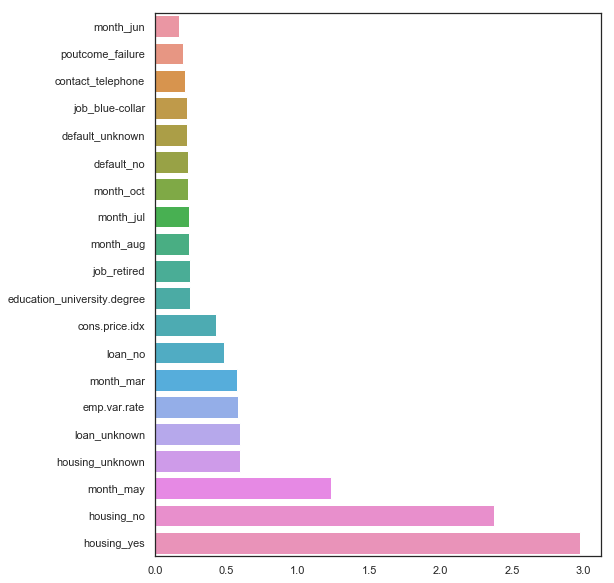

In [17]:
# Baseline: look at coefficient values
sns.set_style('white')
plt.figure(figsize=(8, 10))
idx = np.argsort(np.abs(modified_theta))[-20:]
sns.barplot(np.abs(modified_theta[idx]), X.columns.values[idx])

In [18]:
# Find people in the test set having a housing loan and see how predictions change on them
true_labels = Y_test[test_children_idx]

for i in range(len(test_children_idx)):
    if (orig_model_preds[i] < 0.5) != (modified_model_preds[i] < 0.5):
        print('*** ', end='')
    print("index %s, label %s: %s vs. %s" % (
        test_children_idx[i], true_labels[i], 
        orig_model_preds[i], modified_model_preds[i]))

*** index 0, label 1: 0.27920237 vs. 0.9867671
*** index 1, label 1: 0.1369241 vs. 0.9616971
*** index 2, label 1: 0.33668706 vs. 0.988176
*** index 3, label 1: 0.12314097 vs. 0.96708864
*** index 5, label 1: 0.026155425 vs. 0.84826946
*** index 13, label 1: 0.019877773 vs. 0.78564155
*** index 16, label 1: 0.058577653 vs. 0.927782
*** index 17, label 1: 0.052467406 vs. 0.92352283
*** index 18, label 1: 0.009785501 vs. 0.67711216
*** index 19, label 1: 0.005281534 vs. 0.5035152
*** index 22, label 1: 0.013156092 vs. 0.7279958
*** index 27, label 1: 0.03797317 vs. 0.85695404
*** index 29, label 1: 0.023168257 vs. 0.8359178
*** index 31, label 1: 0.21757317 vs. 0.9823774
*** index 32, label 1: 0.11537074 vs. 0.96988994
*** index 33, label 1: 0.015152743 vs. 0.768199
*** index 34, label 1: 0.022991933 vs. 0.8032552
*** index 35, label 1: 0.043158017 vs. 0.8942275
*** index 36, label 1: 0.054475307 vs. 0.92488694
*** index 37, label 1: 0.25431794 vs. 0.9859089
*** index 38, label 1: 0.0282

*** index 850, label 1: 0.029753817 vs. 0.78556573
*** index 851, label 1: 0.08390592 vs. 0.94674367
*** index 854, label 1: 0.006821551 vs. 0.58156955
*** index 855, label 1: 0.039941702 vs. 0.9221473
*** index 857, label 1: 0.047227047 vs. 0.88414645
*** index 859, label 1: 0.010606096 vs. 0.6930252
*** index 860, label 1: 0.20786656 vs. 0.98325104
*** index 861, label 1: 0.06473381 vs. 0.9321791
*** index 863, label 1: 0.032780666 vs. 0.81843144
*** index 864, label 1: 0.030345755 vs. 0.84816927
*** index 867, label 1: 0.03763391 vs. 0.89961505
index 871, label 1: 0.8609785 vs. 0.9990909
*** index 873, label 1: 0.21011284 vs. 0.9803736
*** index 878, label 1: 0.07148073 vs. 0.9365585
*** index 879, label 1: 0.051504865 vs. 0.8962748
*** index 880, label 1: 0.036628537 vs. 0.8714389
*** index 882, label 1: 0.14332816 vs. 0.9751232
index 883, label 1: 0.8955359 vs. 0.99952304
*** index 884, label 1: 0.03914962 vs. 0.8857554
*** index 886, label 1: 0.00980089 vs. 0.6625441
*** index 89

index 2328, label 1: 0.0047515733 vs. 0.4591993
*** index 2329, label 1: 0.008153594 vs. 0.57373995
*** index 2330, label 1: 0.02225039 vs. 0.81309927
index 2332, label 1: 0.56011826 vs. 0.9963133
*** index 2333, label 1: 0.017647242 vs. 0.7899986
*** index 2335, label 1: 0.034600995 vs. 0.868353
*** index 2336, label 1: 0.021516407 vs. 0.8258115
*** index 2338, label 1: 0.025746008 vs. 0.83796006
*** index 2340, label 1: 0.051879045 vs. 0.9284859
*** index 2348, label 1: 0.015886996 vs. 0.7714657
index 2350, label 1: 0.67424494 vs. 0.99756503
*** index 2351, label 1: 0.13376093 vs. 0.9630189
*** index 2352, label 1: 0.01421015 vs. 0.7593614
*** index 2355, label 1: 0.016604759 vs. 0.711906
*** index 2356, label 1: 0.033087686 vs. 0.84172195
*** index 2357, label 1: 0.05920409 vs. 0.93150854
*** index 2358, label 1: 0.38050896 vs. 0.99338007
*** index 2359, label 1: 0.32500735 vs. 0.9914938
*** index 2360, label 1: 0.024876138 vs. 0.8730928
*** index 2361, label 1: 0.093826436 vs. 0.95

*** index 3006, label 1: 0.027631778 vs. 0.86605996
*** index 3007, label 1: 0.007497654 vs. 0.53393006
*** index 3010, label 1: 0.007997575 vs. 0.63697606
*** index 3013, label 1: 0.019894429 vs. 0.797351
index 3014, label 1: 0.5241226 vs. 0.9958723
*** index 3016, label 1: 0.013025981 vs. 0.7318955
*** index 3017, label 1: 0.018416472 vs. 0.8210649
*** index 3019, label 1: 0.038701657 vs. 0.85229605
*** index 3020, label 1: 0.034035146 vs. 0.8746258
*** index 3021, label 1: 0.17835248 vs. 0.97744226
*** index 3023, label 1: 0.021312242 vs. 0.7761945
*** index 3024, label 1: 0.023147717 vs. 0.8307862
*** index 3026, label 1: 0.046259742 vs. 0.88663834
*** index 3027, label 1: 0.042871125 vs. 0.9141037
*** index 3028, label 1: 0.08802913 vs. 0.9612269
*** index 3030, label 1: 0.040683724 vs. 0.9131679
*** index 3031, label 1: 0.10273643 vs. 0.96074605
*** index 3032, label 1: 0.02359859 vs. 0.87686235
*** index 3033, label 1: 0.039400645 vs. 0.92077214
*** index 3034, label 1: 0.030385

*** index 4370, label 1: 0.13412689 vs. 0.9727677
*** index 4371, label 1: 0.27164474 vs. 0.983712
*** index 4373, label 1: 0.20835945 vs. 0.98029447
*** index 4374, label 1: 0.33492243 vs. 0.9887128
*** index 4375, label 1: 0.07218039 vs. 0.94291794
*** index 4377, label 1: 0.034094773 vs. 0.85303783
*** index 4379, label 1: 0.010700661 vs. 0.6678225
*** index 4380, label 1: 0.28060403 vs. 0.9872629
*** index 4381, label 1: 0.06192849 vs. 0.9017319
*** index 4382, label 1: 0.2814511 vs. 0.98477423
*** index 4384, label 1: 0.02282645 vs. 0.8180218
*** index 4386, label 1: 0.024674658 vs. 0.82299185
*** index 4389, label 1: 0.0107991155 vs. 0.6709722
index 4390, label 1: 0.005233593 vs. 0.42526674
index 4393, label 1: 0.74752814 vs. 0.99842924
*** index 4395, label 1: 0.42630014 vs. 0.99460214
*** index 4396, label 1: 0.029440362 vs. 0.83536494
*** index 4397, label 1: 0.009250935 vs. 0.62365085
*** index 4400, label 1: 0.01033057 vs. 0.64826894
*** index 4404, label 1: 0.017244715 vs. 

*** index 5345, label 1: 0.009028774 vs. 0.5455439
*** index 5346, label 1: 0.012566641 vs. 0.69854
*** index 5351, label 1: 0.009477187 vs. 0.6003156
*** index 5352, label 1: 0.13439648 vs. 0.9642906
*** index 5353, label 1: 0.06319539 vs. 0.9189378
*** index 5356, label 1: 0.006328166 vs. 0.5479819
*** index 5357, label 1: 0.012252119 vs. 0.6609114
*** index 5359, label 1: 0.031370692 vs. 0.86881423
*** index 5360, label 1: 0.06984695 vs. 0.9380198
*** index 5361, label 1: 0.02790479 vs. 0.85732114
*** index 5363, label 1: 0.114700854 vs. 0.969386
*** index 5364, label 1: 0.40273795 vs. 0.9920974
*** index 5366, label 1: 0.02689443 vs. 0.88060665
*** index 5368, label 1: 0.025723344 vs. 0.7751876
*** index 5370, label 1: 0.036346376 vs. 0.8813363
*** index 5376, label 1: 0.4748452 vs. 0.99535614
*** index 5378, label 1: 0.01385773 vs. 0.68726605
*** index 5380, label 1: 0.09184814 vs. 0.9526595
index 5381, label 1: 0.7285477 vs. 0.99770087
*** index 5383, label 1: 0.04414403 vs. 0.90

index 6719, label 1: 0.5558732 vs. 0.996944
*** index 6720, label 1: 0.012125904 vs. 0.6729692
*** index 6721, label 1: 0.025684364 vs. 0.8573254
*** index 6722, label 1: 0.46643642 vs. 0.9954086
*** index 6723, label 1: 0.037477687 vs. 0.85939157
*** index 6725, label 1: 0.03439731 vs. 0.868193
*** index 6728, label 1: 0.007913938 vs. 0.5093459
*** index 6731, label 1: 0.036069088 vs. 0.8658611
*** index 6733, label 1: 0.3622894 vs. 0.99201995
*** index 6734, label 1: 0.061433498 vs. 0.92056125
index 6735, label 1: 0.9456602 vs. 0.99975175
index 6736, label 1: 0.0065155476 vs. 0.4427946
*** index 6739, label 1: 0.080075175 vs. 0.942497
*** index 6740, label 1: 0.0946303 vs. 0.95524955
index 6742, label 1: 0.9953675 vs. 0.99998236
*** index 6743, label 1: 0.060148947 vs. 0.9229744
*** index 6747, label 1: 0.0324109 vs. 0.8497643
*** index 6748, label 1: 0.114729516 vs. 0.9611117
index 6749, label 1: 0.96503717 vs. 0.99985397
*** index 6750, label 1: 0.022735752 vs. 0.8280461
index 6751

*** index 7823, label 1: 0.03361961 vs. 0.85921675
index 7827, label 1: 0.9330537 vs. 0.99965036
*** index 7831, label 1: 0.014151489 vs. 0.71335983
*** index 7832, label 1: 0.16450283 vs. 0.97608554
*** index 7836, label 1: 0.017048769 vs. 0.7339698
*** index 7838, label 1: 0.00962005 vs. 0.6557702
*** index 7839, label 1: 0.06324238 vs. 0.9343308
*** index 7843, label 1: 0.045330618 vs. 0.8938724
*** index 7844, label 1: 0.10852729 vs. 0.956372
*** index 7845, label 1: 0.05059329 vs. 0.9206928
*** index 7846, label 1: 0.018602056 vs. 0.77994514
*** index 7847, label 1: 0.019278565 vs. 0.8022713
*** index 7848, label 1: 0.033436168 vs. 0.89148337
*** index 7849, label 1: 0.039639566 vs. 0.88085836
*** index 7851, label 1: 0.025428632 vs. 0.83395994
*** index 7852, label 1: 0.033017337 vs. 0.88700473
index 7853, label 1: 0.5507405 vs. 0.99566203
*** index 7854, label 1: 0.10715138 vs. 0.96280754
*** index 7855, label 1: 0.016782343 vs. 0.7291206
*** index 7856, label 1: 0.011348861 vs.

*** index 8776, label 1: 0.1514249 vs. 0.9740926
*** index 8780, label 1: 0.3381881 vs. 0.99331397
*** index 8781, label 1: 0.022501983 vs. 0.80545473
index 8782, label 1: 0.8211943 vs. 0.99891424
*** index 8785, label 1: 0.10424948 vs. 0.9570148
*** index 8787, label 1: 0.02606347 vs. 0.8238986
*** index 8790, label 1: 0.015344117 vs. 0.7901251
*** index 8793, label 1: 0.022233963 vs. 0.82764864
*** index 8794, label 1: 0.177657 vs. 0.97242266
*** index 8795, label 1: 0.48592937 vs. 0.9960104
*** index 8796, label 1: 0.01389913 vs. 0.63093007
*** index 8804, label 1: 0.05535392 vs. 0.9206326
*** index 8807, label 1: 0.020595623 vs. 0.7714214
index 8808, label 1: 0.8301901 vs. 0.99899155
*** index 8809, label 1: 0.04381763 vs. 0.90708256
*** index 8811, label 1: 0.03340327 vs. 0.84411055
*** index 8813, label 1: 0.083950214 vs. 0.9562159
*** index 8814, label 1: 0.020995816 vs. 0.7585239
*** index 8816, label 1: 0.054867636 vs. 0.9234304
*** index 8817, label 1: 0.04444569 vs. 0.873198

*** index 10708, label 1: 0.019791447 vs. 0.79731405
*** index 10709, label 1: 0.09240714 vs. 0.9527865
*** index 10711, label 1: 0.011491281 vs. 0.6910911
*** index 10712, label 1: 0.044292998 vs. 0.93627906
*** index 10713, label 1: 0.05089925 vs. 0.91647536
*** index 10714, label 1: 0.047710173 vs. 0.9355968
*** index 10716, label 1: 0.04915432 vs. 0.9178321
*** index 10717, label 1: 0.08789571 vs. 0.9510226
index 10723, label 1: 0.5758862 vs. 0.99708635
*** index 10725, label 1: 0.03155226 vs. 0.8305501
*** index 10726, label 1: 0.02223927 vs. 0.8068265
*** index 10727, label 1: 0.0966072 vs. 0.9504317
index 10730, label 1: 0.8635279 vs. 0.9992937
*** index 10731, label 1: 0.044099145 vs. 0.9100495
index 10732, label 1: 0.6862362 vs. 0.9978036
*** index 10733, label 1: 0.030979082 vs. 0.8340634
*** index 10734, label 1: 0.05573434 vs. 0.933798
*** index 10739, label 1: 0.033564255 vs. 0.8605221
*** index 10743, label 1: 0.022921085 vs. 0.823497
*** index 10745, label 1: 0.39731985 

*** index 12517, label 1: 0.039519496 vs. 0.8521543
*** index 12518, label 1: 0.070750214 vs. 0.93238384
*** index 12519, label 1: 0.01684395 vs. 0.7923921
*** index 12521, label 1: 0.015323728 vs. 0.7001609
*** index 12525, label 1: 0.32152823 vs. 0.99234515
*** index 12526, label 1: 0.04208604 vs. 0.8967571
index 12530, label 1: 0.0039602458 vs. 0.37301806
*** index 12532, label 1: 0.18157876 vs. 0.97702414
*** index 12533, label 1: 0.050299097 vs. 0.91272867
*** index 12536, label 1: 0.041321203 vs. 0.89158815
*** index 12538, label 1: 0.4100105 vs. 0.99502087
*** index 12539, label 1: 0.057298455 vs. 0.92872024
*** index 12540, label 1: 0.03386138 vs. 0.88619477
*** index 12541, label 1: 0.028376862 vs. 0.8550204
*** index 12543, label 1: 0.17705145 vs. 0.968135
*** index 12546, label 1: 0.022068951 vs. 0.85445344
*** index 12548, label 1: 0.121918745 vs. 0.9674626
*** index 12549, label 1: 0.10682628 vs. 0.9655993
*** index 12551, label 1: 0.071793795 vs. 0.9370269
*** index 12552

*** index 14661, label 1: 0.07109357 vs. 0.93739414
*** index 14662, label 1: 0.09370781 vs. 0.95397115
*** index 14668, label 1: 0.20298634 vs. 0.9825745
*** index 14669, label 1: 0.02171681 vs. 0.7885145
index 14673, label 1: 0.8515641 vs. 0.9991573
*** index 14674, label 1: 0.024125118 vs. 0.8099809
index 14676, label 1: 0.99999976 vs. 1.0
*** index 14677, label 1: 0.0067674657 vs. 0.5181338
*** index 14678, label 1: 0.29031077 vs. 0.99005556
*** index 14681, label 1: 0.022865282 vs. 0.7935106
*** index 14682, label 1: 0.16899243 vs. 0.978867
*** index 14683, label 1: 0.111765005 vs. 0.95917654
*** index 14685, label 1: 0.022367705 vs. 0.8122584
*** index 14687, label 1: 0.032009095 vs. 0.8264039
*** index 14689, label 1: 0.04211003 vs. 0.90566933
*** index 14691, label 1: 0.035058666 vs. 0.89482176
*** index 14692, label 1: 0.066383354 vs. 0.9349277
*** index 14693, label 1: 0.047286306 vs. 0.9164327
*** index 14694, label 1: 0.020598238 vs. 0.79773843
*** index 14695, label 1: 0.0

*** index 15752, label 1: 0.06947464 vs. 0.9396537
*** index 15754, label 1: 0.43202782 vs. 0.994062
*** index 15755, label 1: 0.0325185 vs. 0.8619205
*** index 15757, label 1: 0.021607347 vs. 0.8206935
*** index 15758, label 1: 0.056774255 vs. 0.8965454
*** index 15760, label 1: 0.0140988445 vs. 0.7247615
*** index 15763, label 1: 0.0159495 vs. 0.7708147
*** index 15765, label 1: 0.08677283 vs. 0.9566157
index 15766, label 1: 0.65347254 vs. 0.9976586
*** index 15767, label 1: 0.016686307 vs. 0.7531271
*** index 15770, label 1: 0.054810897 vs. 0.92824936
*** index 15771, label 1: 0.078060046 vs. 0.9390467
*** index 15772, label 1: 0.021181272 vs. 0.81123537
*** index 15773, label 1: 0.046184067 vs. 0.8606814
*** index 15774, label 1: 0.09100872 vs. 0.94456923
*** index 15775, label 1: 0.28936934 vs. 0.98820484
*** index 15776, label 1: 0.075183295 vs. 0.94082636
*** index 15777, label 1: 0.18488705 vs. 0.98132527
*** index 15780, label 1: 0.170839 vs. 0.9765837
*** index 15782, label 1

*** index 17267, label 1: 0.13509296 vs. 0.96863204
*** index 17268, label 1: 0.30865568 vs. 0.9894097
*** index 17269, label 1: 0.019331865 vs. 0.75308096
*** index 17270, label 1: 0.012943701 vs. 0.7121946
*** index 17272, label 1: 0.12580316 vs. 0.9689762
*** index 17273, label 1: 0.03715783 vs. 0.8864964
*** index 17274, label 1: 0.025378859 vs. 0.8203627
*** index 17275, label 1: 0.03814551 vs. 0.8879411
*** index 17276, label 1: 0.36977103 vs. 0.99054855
*** index 17277, label 1: 0.014784963 vs. 0.75814915
*** index 17280, label 1: 0.0632286 vs. 0.9462698
*** index 17281, label 1: 0.029315053 vs. 0.8152336
*** index 17283, label 1: 0.013510727 vs. 0.6894102
*** index 17284, label 1: 0.030660832 vs. 0.8560059
*** index 17286, label 1: 0.008530318 vs. 0.63551325
*** index 17287, label 1: 0.035915554 vs. 0.90456563
*** index 17288, label 1: 0.35570145 vs. 0.99019873
*** index 17289, label 1: 0.3902398 vs. 0.9920477
index 17293, label 1: 0.80705523 vs. 0.9985494
index 17295, label 1:

*** index 18207, label 1: 0.15675376 vs. 0.97484064
*** index 18208, label 1: 0.035062283 vs. 0.8348013
*** index 18209, label 1: 0.024398562 vs. 0.8132668
*** index 18210, label 1: 0.0057247723 vs. 0.52924913
*** index 18211, label 1: 0.059251487 vs. 0.9319436
*** index 18214, label 1: 0.007995063 vs. 0.5996701
*** index 18215, label 1: 0.15719092 vs. 0.9711963
*** index 18216, label 1: 0.080608726 vs. 0.9215092
*** index 18219, label 1: 0.04617533 vs. 0.92492324
*** index 18222, label 1: 0.30601722 vs. 0.98695415
*** index 18224, label 1: 0.047783367 vs. 0.92273563
*** index 18225, label 1: 0.12086985 vs. 0.94995254
*** index 18227, label 1: 0.04500258 vs. 0.90109587
*** index 18232, label 1: 0.031504735 vs. 0.8681554
*** index 18234, label 1: 0.009753139 vs. 0.6771964
*** index 18235, label 1: 0.014519892 vs. 0.70204914
*** index 18238, label 1: 0.024173932 vs. 0.7700793
*** index 18239, label 1: 0.03734485 vs. 0.8703366
*** index 18243, label 1: 0.015069628 vs. 0.7269294
*** index 

*** index 19264, label 1: 0.027465202 vs. 0.83758783
*** index 19266, label 1: 0.018295152 vs. 0.74892443
*** index 19267, label 1: 0.094393946 vs. 0.9523373
*** index 19269, label 1: 0.33480775 vs. 0.99146616
*** index 19270, label 1: 0.027426304 vs. 0.84149265
*** index 19272, label 1: 0.048446566 vs. 0.87496257
*** index 19277, label 1: 0.01835135 vs. 0.75543827
index 19278, label 1: 0.50185204 vs. 0.99431545
*** index 19284, label 1: 0.013988294 vs. 0.6959357
*** index 19286, label 1: 0.017151225 vs. 0.72565013
*** index 19288, label 1: 0.038515605 vs. 0.87298906
*** index 19289, label 1: 0.014588116 vs. 0.6122309
*** index 19290, label 1: 0.018203434 vs. 0.80836755
index 19293, label 1: 0.7539418 vs. 0.99777263
*** index 19294, label 1: 0.083662294 vs. 0.95420074
*** index 19295, label 1: 0.43177322 vs. 0.99303764
*** index 19296, label 1: 0.020575933 vs. 0.8153865
index 19297, label 1: 0.51982033 vs. 0.994831
*** index 19298, label 1: 0.03741664 vs. 0.8899394
*** index 19299, lab

*** index 20507, label 1: 0.094863586 vs. 0.9672049
*** index 20508, label 1: 0.054500856 vs. 0.92173296
*** index 20510, label 1: 0.015780294 vs. 0.65213585
*** index 20512, label 1: 0.11782924 vs. 0.95914614
*** index 20513, label 1: 0.022805272 vs. 0.83233094
*** index 20514, label 1: 0.060167275 vs. 0.92669284
*** index 20515, label 1: 0.06617561 vs. 0.94881755
*** index 20517, label 1: 0.039248463 vs. 0.9128974
*** index 20519, label 1: 0.019811219 vs. 0.78378683
*** index 20522, label 1: 0.047039792 vs. 0.89984596
*** index 20524, label 1: 0.03042589 vs. 0.85638255
*** index 20525, label 1: 0.035443578 vs. 0.8853882
*** index 20526, label 1: 0.05734483 vs. 0.9033628
*** index 20527, label 1: 0.051978208 vs. 0.8879085
index 20528, label 1: 0.6692696 vs. 0.9977986
*** index 20530, label 1: 0.044459462 vs. 0.9043164
*** index 20531, label 1: 0.03531768 vs. 0.88220763
*** index 20533, label 1: 0.13771403 vs. 0.97409487
*** index 20535, label 1: 0.17888528 vs. 0.97310853
*** index 205

*** index 21703, label 1: 0.12260402 vs. 0.9690158
*** index 21709, label 1: 0.04162008 vs. 0.9216809
*** index 21710, label 1: 0.023085695 vs. 0.80547684
*** index 21711, label 1: 0.045380667 vs. 0.885117
*** index 21712, label 1: 0.021890108 vs. 0.8211209
*** index 21717, label 1: 0.007943704 vs. 0.56850475
index 21720, label 1: 0.6769253 vs. 0.9981193
*** index 21722, label 1: 0.040126126 vs. 0.8669786
index 21724, label 1: 0.00448939 vs. 0.46677154
*** index 21725, label 1: 0.024124399 vs. 0.8151911
*** index 21726, label 1: 0.03956383 vs. 0.8893056
*** index 21727, label 1: 0.041346904 vs. 0.88935596
index 21728, label 1: 0.0058450657 vs. 0.3074035
*** index 21729, label 1: 0.060277596 vs. 0.88568556
*** index 21732, label 1: 0.045637842 vs. 0.90170825
*** index 21735, label 1: 0.1747863 vs. 0.9812955
*** index 21736, label 1: 0.15611747 vs. 0.97117525
*** index 21739, label 1: 0.3222743 vs. 0.9908642
*** index 21740, label 1: 0.026710646 vs. 0.830769
*** index 21743, label 1: 0.0

index 22803, label 1: 0.77380717 vs. 0.9985293
*** index 22804, label 1: 0.042358465 vs. 0.90545434
*** index 22805, label 1: 0.035917927 vs. 0.88034457
*** index 22806, label 1: 0.12723352 vs. 0.96070355
*** index 22807, label 1: 0.021363623 vs. 0.7826956
*** index 22809, label 1: 0.016814852 vs. 0.8109484
*** index 22810, label 1: 0.48914412 vs. 0.99404305
*** index 22811, label 1: 0.05955778 vs. 0.906979
*** index 22813, label 1: 0.23168957 vs. 0.98305815
*** index 22814, label 1: 0.12839063 vs. 0.97338337
*** index 22816, label 1: 0.044039525 vs. 0.9169625
*** index 22817, label 1: 0.072237894 vs. 0.9324028
*** index 22818, label 1: 0.049158596 vs. 0.9111516
index 22820, label 1: 0.010996274 vs. 0.48584557
*** index 22821, label 1: 0.012243628 vs. 0.6739105
*** index 22822, label 1: 0.02493404 vs. 0.80325216
*** index 22824, label 1: 0.026989533 vs. 0.80675036
*** index 22827, label 1: 0.011584688 vs. 0.68620086
*** index 22833, label 1: 0.027540602 vs. 0.8576126
*** index 22835, l

*** index 24926, label 1: 0.075653054 vs. 0.9265391
*** index 24927, label 1: 0.020224735 vs. 0.7822268
*** index 24928, label 1: 0.022630801 vs. 0.80429184
*** index 24930, label 1: 0.24904607 vs. 0.983347
*** index 24931, label 1: 0.015705228 vs. 0.76353055
*** index 24932, label 1: 0.13224247 vs. 0.9660723
*** index 24934, label 1: 0.04376907 vs. 0.91389686
*** index 24935, label 1: 0.01940722 vs. 0.7879401
index 24937, label 1: 0.521375 vs. 0.9959644
*** index 24938, label 1: 0.012957939 vs. 0.7218007
*** index 24939, label 1: 0.026320722 vs. 0.8087355
*** index 24940, label 1: 0.032033928 vs. 0.8825137
*** index 24944, label 1: 0.04942854 vs. 0.9216614
*** index 24946, label 1: 0.07741025 vs. 0.9389794
*** index 24947, label 1: 0.22535801 vs. 0.9867265
*** index 24948, label 1: 0.05899409 vs. 0.9303271
*** index 24951, label 1: 0.03199823 vs. 0.88446563
*** index 24952, label 1: 0.0063541257 vs. 0.56425136
*** index 24953, label 1: 0.15440688 vs. 0.9794636
*** index 24954, label 1

*** index 26410, label 1: 0.035476197 vs. 0.87325835
*** index 26412, label 1: 0.4038405 vs. 0.99112904
*** index 26413, label 1: 0.036235236 vs. 0.8556468
*** index 26415, label 1: 0.07047634 vs. 0.93360347
index 26416, label 1: 0.69812286 vs. 0.99804115
*** index 26417, label 1: 0.12233918 vs. 0.9666746
*** index 26418, label 1: 0.037901748 vs. 0.89827436
*** index 26421, label 1: 0.08844621 vs. 0.9328389
*** index 26425, label 1: 0.034753334 vs. 0.8971024
*** index 26427, label 1: 0.033269037 vs. 0.8465128
*** index 26428, label 1: 0.06097344 vs. 0.93367314
index 26432, label 1: 0.93300927 vs. 0.99972624
index 26434, label 1: 0.5733024 vs. 0.99704486
*** index 26437, label 1: 0.0146895265 vs. 0.7790107
*** index 26438, label 1: 0.039041713 vs. 0.90624166
*** index 26439, label 1: 0.03824908 vs. 0.8664096
*** index 26440, label 1: 0.020901695 vs. 0.7673679
*** index 26441, label 1: 0.048248757 vs. 0.9152522
*** index 26442, label 1: 0.032423705 vs. 0.82752895
index 26444, label 1: 0.

In [21]:
# Pick one of those people and find the most influential examples on it
test_idx = 1
x_test = X_test[test_idx, :]
y_test = Y_test[test_idx]
print("Test point features:")
print(x_test)
print(y_test)
#print('Younger than 10? %s' % x_test[loan_var_indices[2]])

influences = modified_model.get_influence_on_test_loss(
    test_indices=[1],
    train_idx=np.arange(len(modified_model.data_sets.train.labels)))

top_k = 10
helpful_points = np.argsort(influences)[-top_k:][::-1]
unhelpful_points = np.argsort(influences)[:top_k]

influences_to_plot = []
ages_to_plot = []

for points, message in [
    (unhelpful_points, 'worse'), (helpful_points, 'better')]:
    print("Top %s training points making the loss on the test point %s:" % (top_k, message))
    for counter, idx in enumerate(points):
        print("#%5d, class=%s, housing=%s, predicted_loss_diff=%.8f" % (
            idx,                 
            modified_Y_train[idx], 
            modified_X_train[idx, loan_var_indices],
            influences[idx]))
        
        ages_to_plot.append(idx)
        influences_to_plot.append(influences[idx])
#housing = 0 0 1 indicates people who have housing loan, 
#each of the variable is an indicator of whether that sample has a housing loan or not, or is unknown

Test point features:
[ 5.6000e+01  4.5700e+02  1.0000e+00  9.9900e+02  1.0000e+00 -1.0000e-01
  9.3200e+01 -4.2000e+01  4.1200e+00  5.1958e+03  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00  0.0000e+00  0.0000e+00
  1.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00  0.0000e+00  0.0000e+00
  0.0000e+00  0.0000e+00  0.0000e+00  0.0000e+00  1.0000e+00  1.0000e+00
  0.0000e+00  0.0000e+00]
1
Norm of test gradient: 5108.4863
Function value: 19348415.80078125
Split function value: 19356578.0, -8162.199
Predicted loss diff on train_idx 5: -0.03435807800130831
Function value: 10434.241577148438
Split function val

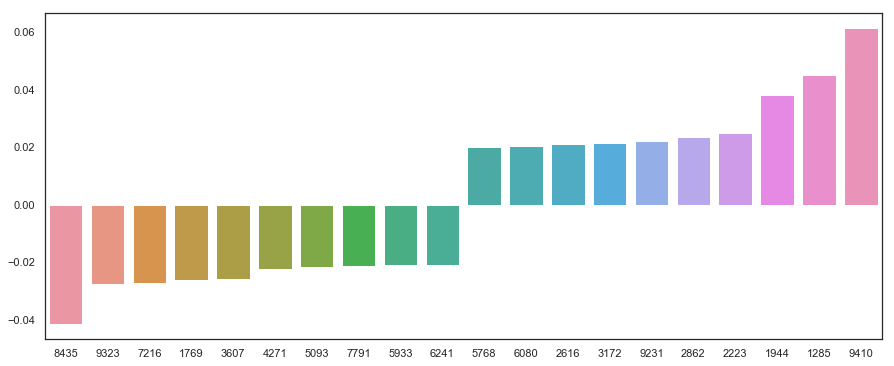

In [22]:
# The people in the modified dataset are by far the most influential
plt.figure(figsize=(15,6))
sort_idx = np.argsort(influences_to_plot)
ages_to_plot = np.array(ages_to_plot)
sns.barplot(ages_to_plot, influences_to_plot, order=ages_to_plot[sort_idx])

Norm of test gradient: 5108.4863
Loaded inverse HVP from output\diabetes_logreg-cg-normal_loss-test-[1].npz
Inverse HVP took 0.003018617630004883 sec


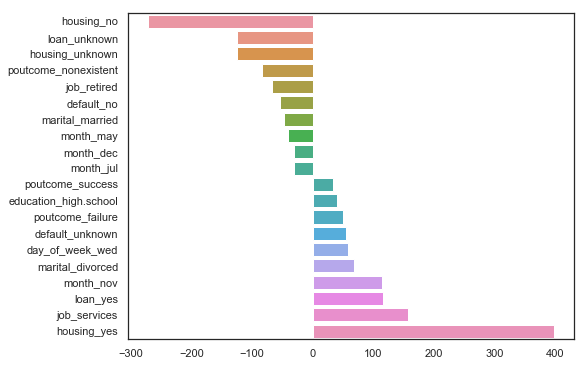

In [23]:
# Look at which features are causing this influence
grad_influences_wrt_input_val = modified_model.get_grad_of_influence_wrt_input(
    [9410, 8435, 9323, 7216], 
    [test_idx], 
    force_refresh=False,
    test_description=None,
    loss_type='normal_loss')    

delta = grad_influences_wrt_input_val[0, :]
plt.figure(figsize=(8, 6))
idx_to_plot = np.array([0] * len(delta), dtype=bool)
idx_to_plot[:10] = 1
idx_to_plot[-10:] = 1
sns.barplot(np.sort(delta)[idx_to_plot], feature_names[np.argsort(delta)[idx_to_plot]], orient='h')